### Without % Change

In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

# Load data
data_2023 = pd.read_csv('2023data.csv')
data_2024 = pd.read_csv('2024data.csv')

# Interpolate missing values in the 'NDX' column
data_2023['NDX'].interpolate(method='linear', inplace=True)

# Calculate the correlation matrix directly from stock prices
correlation_matrix = data_2023.iloc[:, 2:].corr()  # Exclude 'Date' and 'NDX'

# List of stock names (excluding 'Date' and 'NDX')
stock_names = data_2023.columns[2:].tolist()  # Adjusted to skip the first two columns

# Integer Programming Model
def create_portfolio(m):
    model = gp.Model("Index Fund Selection")
    
    n = len(correlation_matrix)
    
    # Decision Variables
    y = model.addVars(n, vtype=GRB.BINARY, name="y")  # Select stocks
    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")  # Representative mapping
    
    # Objective: Maximize similarity
    model.setObjective(gp.quicksum(correlation_matrix.iat[i, j] * x[i, j] 
                                     for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    
    # Constraints
    model.addConstr(gp.quicksum(y[j] for j in range(n)) == m, "Select_m_stocks")
    for i in range(n):
        model.addConstr(gp.quicksum(x[i, j] for j in range(n)) == 1, f"One_rep_for_stock_{i}")
        for j in range(n):
            model.addConstr(x[i, j] <= y[j], f"Link_to_fund_{i}_{j}")

    model.optimize()

    # Extract results
    selected_stocks_indices = [j for j in range(n) if y[j].x > 0.5]
    selected_stocks_names = [stock_names[j] for j in selected_stocks_indices]  # Get stock names
    
    return selected_stocks_indices, selected_stocks_names

# Example for m = 5
selected_indices, selected_names = create_portfolio(5)

print("Selected Stock Indices:", selected_indices)
print("Selected Stock Names:", selected_names)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6616\3772429107.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2023['NDX'].interpolate(method='linear', inplace=True)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10101 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0x8415c4dc
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 29.4260943
Presolve time: 0.08s
Presolved: 10101 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)
Found heuristic solution: objective 78.1729680

Root relaxation: objective 8.600318e+01, 1093 iterations, 0.05 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

### Weights Calculation

In [10]:
# Function to calculate stock returns (percentage change)
def calculate_returns(data):
    return data.pct_change().dropna()

# Calculate returns for the selected stocks and the index
returns_data_2023 = calculate_returns(data_2023.set_index('Date'))
index_returns_2023 = returns_data_2023['NDX']
selected_stock_returns = returns_data_2023[selected_names].values.T  # Transpose to get (n_stocks, T)

n_stocks = len(selected_names)  # Number of selected stocks
T = len(index_returns_2023)     # Number of time periods

# Gurobi Model for Portfolio Weight Optimization
def optimize_portfolio_weights(selected_stock_returns, index_returns_2023):
    # Create a new model
    model = gp.Model("portfolio_weight_optimization")
    
    # Add weight variables (w_i), one for each selected stock
    weights = model.addVars(n_stocks, lb=0, ub=1, name="weights")
    
    # Add auxiliary variables for absolute deviations (y_t)
    y = model.addVars(T, lb=0, name="abs_dev")
    
    # Set the objective: minimize sum of absolute deviations between portfolio and index returns
    model.setObjective(gp.quicksum(y[t] for t in range(T)), GRB.MINIMIZE)
    
    # Add constraints to ensure absolute deviation formulation
    for t in range(T):
        # Portfolio return at time t is the sum of stock returns weighted by weights
        portfolio_return = gp.quicksum(weights[i] * selected_stock_returns[i, t] for i in range(n_stocks))
        
        # Constraints for absolute deviation y_t >= |q_t - portfolio_return|
        model.addConstr(y[t] >= index_returns_2023[t] - portfolio_return)
        model.addConstr(y[t] >= portfolio_return - index_returns_2023[t])
    
    # Constraint to ensure sum of weights is equal to 1 (Σw_i = 1)
    model.addConstr(gp.quicksum(weights[i] for i in range(n_stocks)) == 1, "sum_weights")
    
    # Optimize the model
    model.optimize()
    
    # Extract and return the optimal weights
    if model.status == GRB.OPTIMAL:
        optimal_weights = {selected_names[i]: weights[i].x for i in range(n_stocks)}
        return optimal_weights
    else:
        print("No optimal solution found.")
        return None

# Optimize portfolio weights for the selected stocks
optimal_weights = optimize_portfolio_weights(selected_stock_returns, index_returns_2023)

# Output the optimal weights
print("Optimal Portfolio Weights:")
if optimal_weights:
    for stock, weight in optimal_weights.items():
        print(f"{stock}: {weight:.4f}")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 149 rows, 79 columns and 883 nonzeros
Model fingerprint: 0x373d6cc6
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+00]
Presolve time: 0.01s
Presolved: 149 rows, 79 columns, 883 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.601978e-01   0.000000e+00      0s
      77    3.7035838e-01   0.000000e+00   0.000000e+00      0s

Solved in 77 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.703583799e-01
Optimal Portfolio Weights:
AMZN: 0.4319
AEP: 0.1862
ARM: 0.0650
BKR: 0.0740
PEP: 0.2429


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16596\1992028452.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16596\1992028452.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(y[t] >= index_returns_2023[t] - portfolio_return)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16596\1992028452.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

### With % Change

In [15]:
# Load packages
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Load data
data_2023 = pd.read_csv('2023data.csv')
data_2024 = pd.read_csv('2024data.csv')

# Interpolate missing values in the 'NDX' column
data_2023['NDX'].interpolate(method='linear', inplace=True)
data_2024['NDX'].interpolate(method='linear', inplace=True)

# Calculate daily returns for all stocks and the index
returns_2023 = data_2023.set_index('Date').pct_change().dropna()
returns_2024 = data_2024.set_index('Date').pct_change().dropna()

# Calculate correlation matrix from returns data
correlation_matrix = returns_2023.iloc[:, 1:].corr()  # Exclude the index column

# List of stock names (excluding 'NDX')
stock_names = returns_2023.columns[1:].tolist()  # Adjust to skip the 'NDX' column


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26472\2649584293.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2023['NDX'].interpolate(method='linear', inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26472\2649584293.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [16]:
# Integer Programming Model for Company Selection
def create_portfolio(m):
    model = gp.Model("Index Fund Selection")
    
    n = len(correlation_matrix)
    
    # Decision Variables
    y = model.addVars(n, vtype=GRB.BINARY, name="y")  # Select stocks
    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")  # Representative mapping
    
    # Objective: Maximize similarity
    model.setObjective(gp.quicksum(correlation_matrix.iat[i, j] * x[i, j] 
                                     for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    
    # Constraints
    model.addConstr(gp.quicksum(y[j] for j in range(n)) == m, "Select_m_stocks")
    for i in range(n):
        model.addConstr(gp.quicksum(x[i, j] for j in range(n)) == 1, f"One_rep_for_stock_{i}")
        for j in range(n):
            model.addConstr(x[i, j] <= y[j], f"Link_to_fund_{i}_{j}")

    model.optimize()

    # Extract and print results
    selected_stocks_indices = [j for j in range(n) if y[j].x > 0.5]
    selected_stocks_names = [stock_names[j] for j in selected_stocks_indices]
    
    print(f"\nSelected Stocks for m = {m}: {selected_stocks_names}")
    
    return selected_stocks_indices, selected_stocks_names

# Example: Select stocks for m = 5
selected_indices, selected_names = create_portfolio(5)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10101 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0xf7f6873a
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 25.9966049
Presolve time: 0.12s
Presolved: 10101 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)
Found heuristic solution: objective 44.3125360

Root relaxation: objective 5.832240e+01, 1215 iterations, 0.06 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

In [17]:
# Function to calculate portfolio weights for selected stocks
def calculate_portfolio_weights(selected_names, returns_2023):
    # Extract returns for the selected stocks and the index
    selected_stock_returns = returns_2023[selected_names].values.T  # Transpose for (n_stocks, T)
    index_returns = returns_2023['NDX']
    
    n_stocks = len(selected_names)  # Number of selected stocks
    T = len(index_returns)          # Number of time periods

    # Gurobi Model for Portfolio Weight Optimization
    model = gp.Model("Portfolio Weight Optimization")
    
    # Add weight variables (w_i) for each selected stock
    weights = model.addVars(n_stocks, lb=0, ub=1, name="weights")
    
    # Add auxiliary variables for absolute deviations (y_t)
    y = model.addVars(T, lb=0, name="abs_dev")
    
    # Set the objective: minimize sum of absolute deviations
    model.setObjective(gp.quicksum(y[t] for t in range(T)), GRB.MINIMIZE)
    
    # Constraints to ensure absolute deviation formulation
    for t in range(T):
        portfolio_return = gp.quicksum(weights[i] * selected_stock_returns[i, t] for i in range(n_stocks))
        model.addConstr(y[t] >= index_returns[t] - portfolio_return)
        model.addConstr(y[t] >= portfolio_return - index_returns[t])
    
    # Constraint for sum of weights equal to 1
    model.addConstr(gp.quicksum(weights[i] for i in range(n_stocks)) == 1, "sum_weights")
    
    model.optimize()

    # Extract and print the optimal weights
    if model.status == GRB.OPTIMAL:
        optimal_weights = {selected_names[i]: weights[i].x for i in range(n_stocks)}
        print("\nOptimal Weights for Selected Portfolio:")
        for stock, weight in optimal_weights.items():
            print(f"{stock}: {weight:.4f}")
        return optimal_weights
    else:
        print("No optimal solution found.")
        return None

# Calculate and display portfolio weights
optimal_weights = calculate_portfolio_weights(selected_names, returns_2023)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 149 rows, 79 columns and 891 nonzeros
Model fingerprint: 0xeebaabef
Coefficient statistics:
  Matrix range     [4e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+00]
Presolve removed 6 rows and 3 columns
Presolve time: 0.01s
Presolved: 143 rows, 76 columns, 855 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3666389e-03   4.944266e-01   0.000000e+00      0s
      76    2.8124178e-01   0.000000e+00   0.000000e+00      0s

Solved in 76 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.812417814e-01

Optimal Weights for Selected Portfolio:
BIIB: 0.0712
CPRT: 0.3409
INTU: 0.2519
MCHP: 0.1240
PEP: 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26472\133421583.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(y[t] >= index_returns[t] - portfolio_return)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26472\133421583.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(y[t] >= portfolio_return - index_returns[t])


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10101 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0xf7f6873a
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 25.9966049
Presolve time: 0.06s
Presolved: 10101 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)
Found heuristic solution: objective 44.3125360

Root relaxation: objective 5.832240e+01, 1215 iterations, 0.07 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26472\243460227.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(y[t] >= index_returns[t] - portfolio_return)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26472\243460227.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(y[t] >= portfolio_return - index_returns[t])


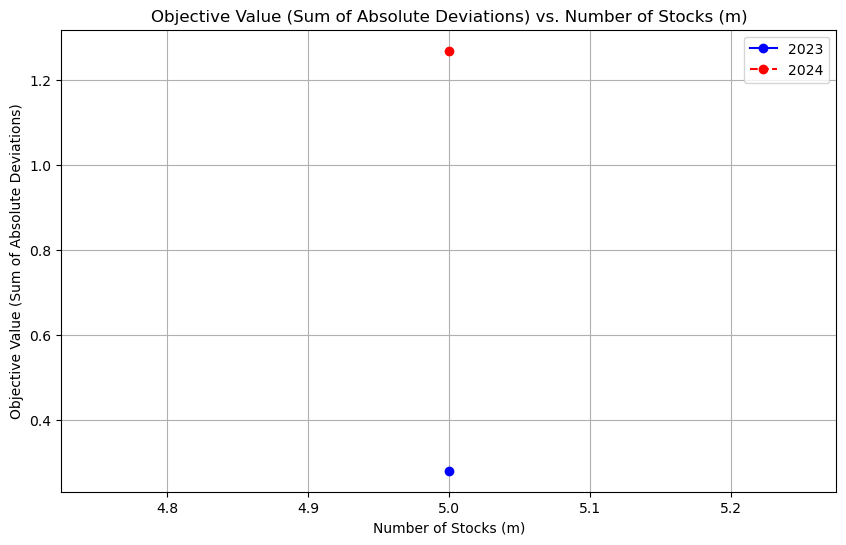

In [18]:

# Function to optimize portfolio weights and return the objective value
def optimize_portfolio_weights(selected_stock_returns, index_returns):
    # Create a new model
    model = gp.Model("portfolio_weight_optimization")
    
    n_stocks = selected_stock_returns.shape[0]
    T = len(index_returns)
    
    # Add weight variables (w_i), one for each selected stock
    weights = model.addVars(n_stocks, lb=0, ub=1, name="weights")
    
    # Add auxiliary variables for absolute deviations (y_t)
    y = model.addVars(T, lb=0, name="abs_dev")
    
    # Set the objective: minimize sum of absolute deviations between portfolio and index returns
    model.setObjective(gp.quicksum(y[t] for t in range(T)), GRB.MINIMIZE)
    
    # Add constraints to ensure absolute deviation formulation
    for t in range(T):
        # Portfolio return at time t is the sum of stock returns weighted by weights
        portfolio_return = gp.quicksum(weights[i] * selected_stock_returns[i, t] for i in range(n_stocks))
        
        # Constraints for absolute deviation y_t >= |q_t - portfolio_return|
        model.addConstr(y[t] >= index_returns[t] - portfolio_return)
        model.addConstr(y[t] >= portfolio_return - index_returns[t])
    
    # Constraint to ensure sum of weights is equal to 1 (Σw_i = 1)
    model.addConstr(gp.quicksum(weights[i] for i in range(n_stocks)) == 1, "sum_weights")
    
    # Optimize the model
    model.optimize()
    
    # Return the optimal objective value (sum of absolute deviations)
    if model.status == GRB.OPTIMAL:
        return model.objVal
    else:
        print("No optimal solution found.")
        return None

# Function to calculate and plot objective values for different m for both 2023 and 2024
def plot_objective_vs_m(m_values, returns_2023, returns_2024):
    objective_values_2023 = []
    objective_values_2024 = []
    
    for m in m_values:
        # Step 1: Select stocks for the current value of m
        _, selected_names = create_portfolio(m)
        print(f"Selected stocks for m = {m}: {selected_names}")
        
        # Step 2: Extract the returns data for the selected stocks
        selected_stock_returns_2023 = returns_2023[selected_names].values.T
        selected_stock_returns_2024 = returns_2024[selected_names].values.T
        
        # Step 3: Calculate objective values for 2023 and 2024 and store them
        objective_value_2023 = optimize_portfolio_weights(selected_stock_returns_2023, returns_2023['NDX'])
        print(f"Objective value for m = {m} in 2023: {objective_value_2023}")
        
        objective_value_2024 = optimize_portfolio_weights(selected_stock_returns_2024, returns_2024['NDX'])
        print(f"Objective value for m = {m} in 2024: {objective_value_2024}")
        
        objective_values_2023.append(objective_value_2023)
        objective_values_2024.append(objective_value_2024)

    # Plotting the objective values as a function of m for both 2023 and 2024
    plt.figure(figsize=(10, 6))
    plt.plot(m_values, objective_values_2023, marker='o', linestyle='-', color='b', label='2023')
    plt.plot(m_values, objective_values_2024, marker='o', linestyle='--', color='r', label='2024')
    plt.title('Objective Value (Sum of Absolute Deviations) vs. Number of Stocks (m)')
    plt.xlabel('Number of Stocks (m)')
    plt.ylabel('Objective Value (Sum of Absolute Deviations)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test and plot for values of m (e.g., 5, 10, 15, 30, 50, 90, 100)
plot_m_values = [5]
plot_objective_vs_m(plot_m_values, returns_2023, returns_2024)


### Part 4 (To be Run by Everyone!! But for this to work you need to run previous blocks of code as well! (For Jyoti to run)

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import pandas as pd
import time  # Import time module for tracking elapsed time

# Interpolate missing values in the 'NDX' column
data_2023['NDX'].interpolate(method='linear', inplace=True)
data_2024['NDX'].interpolate(method='linear', inplace=True)

# Calculate daily returns for all stocks and the index
returns_2023 = data_2023.set_index('Date').pct_change().dropna()
returns_2024 = data_2024.set_index('Date').pct_change().dropna()

# Define index returns (returns of the NDX column)
index_returns_2023 = returns_2023['NDX']
index_returns_2024 = returns_2024['NDX']

# Define stock returns (returns of all stocks, excluding NDX)
stock_returns_2023 = returns_2023.drop(columns=['NDX'])
stock_returns_2024 = returns_2024.drop(columns=['NDX'])

# Set a clearly visible time limit variable in seconds (30 minutes = 1800 seconds)
TIME_LIMIT = 5  # Time limit for each m value optimization

# Function to optimize portfolio weights for given m and return the objective value
def optimize_portfolio_for_m(m, index_returns, stock_returns):
    model = gp.Model("Index Fund Optimization")
    model.setParam("TimeLimit", TIME_LIMIT)  # Set Gurobi time limit

    # Initialize parameters
    n = stock_returns.shape[1]  # Total number of stocks in the index
    T = len(index_returns)       # Number of time periods

    # Decision variables
    w = model.addVars(n, lb=0, ub=1, name="weights")  # Portfolio weights (continuous)
    y = model.addVars(n, vtype=GRB.BINARY, name="y")  # Binary variables to select stocks
    z = model.addVars(T, lb=0, name="deviation")       # Deviation variables to capture absolute differences

    # Objective: Minimize total deviation from index returns
    model.setObjective(gp.quicksum(z[t] for t in range(T)), GRB.MINIMIZE)

    # Constraints
    # Deviation constraints for each time period
    for t in range(T):
        stock_return_t = stock_returns.iloc[t, :].values  # Returns for all stocks at time t
        index_return_t = index_returns[t]                  # NASDAQ-100 return at time t
        model.addConstr(z[t] >= index_return_t - gp.quicksum(w[i] * stock_return_t[i] for i in range(n)))
        model.addConstr(z[t] >= -(index_return_t - gp.quicksum(w[i] * stock_return_t[i] for i in range(n))))

    # Stock selection constraints
    for i in range(n):
        model.addConstr(w[i] <= y[i])  # Force w_i = 0 if y_i = 0
    model.addConstr(gp.quicksum(y[i] for i in range(n)) == m)  # Only m non-zero weights

    # Ensure weights sum to 1
    model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)

    # Solve the model
    model.optimize()

    # Retrieve results if the model finds a solution
    results = pd.DataFrame({
        'Stock': stock_returns.columns,
        'Weight': [w[i].X for i in range(n)],
        'Selected': [y[i].X for i in range(n)]
    })

    selected_stocks = results[results['Selected'] > 0.5]  # Filter selected stocks
    objective_value = model.objVal if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT) else None

    # Save results to CSV including the objective function value
    results['Objective_Value'] = objective_value  # Add objective value to results
    results.to_csv(f"portfolio_results_m_{m}.csv", index=False)
    
    return selected_stocks, objective_value

# Function to calculate and plot objective values for different m
def plot_objective_vs_m(m_values, index_returns, stock_returns):
    objective_values = []
    all_selected_stocks = []

    for m in m_values:
        start_time = time.time()  # Start timing the optimization
        selected_stocks, objective_value = optimize_portfolio_for_m(m, index_returns, stock_returns)
        elapsed_time = time.time() - start_time  # Calculate elapsed time

        if elapsed_time < TIME_LIMIT:  # Only process results if within time limit
            if selected_stocks is not None:
                print(f"Selected stocks for m = {m}: {selected_stocks['Stock'].tolist()}")
                print(f"Objective value for m = {m}: {objective_value}")
                objective_values.append(objective_value)
                all_selected_stocks.append(selected_stocks)
            else:
                objective_values.append(None)  # Append None for unsuccessful optimization
        else:
            print(f"Optimization for m = {m} exceeded the time limit of {TIME_LIMIT} seconds. Moving to next m.")
            objective_values.append(None)  # Append None for unsuccessful optimization

    # Plotting the objective values as a function of m
    plt.figure(figsize=(10, 6))
    plt.plot(m_values, objective_values, marker='o', linestyle='-', color='b')
    plt.title('Objective Value (Sum of Absolute Deviations) vs. Number of Stocks (m)')
    plt.xlabel('Number of Stocks (m)')
    plt.ylabel('Objective Value (Sum of Absolute Deviations)')
    plt.grid(True)
    plt.show()

# Test and plot for values of m (e.g., 5, 10, 15)
plot_m_values = [60,70,80,90,100]
plot_objective_vs_m(plot_m_values, index_returns_2023, stock_returns_2023)

### Train vs Test data

Tracking error for m = 5 (2023): 0.1428339025230749
Tracking error for m = 5 (2024): 0.9031477664794828
Tracking error for m = 10 (2023): 0.07634825306732641
Tracking error for m = 10 (2024): 0.5099123364847338
Tracking error for m = 20 (2023): 0.03289924180874035
Tracking error for m = 20 (2024): 0.45933763559812724
Tracking error for m = 30 (2023): 0.018289555062785012
Tracking error for m = 30 (2024): 0.3608195454521985
Tracking error for m = 40 (2023): 0.009693696581653461
Tracking error for m = 40 (2024): 0.3180090153713935
File not found: portfolio_results_m_50.csv
Tracking error for m = 60 (2023): 0.0051207756476387796
Tracking error for m = 60 (2024): 0.31090928503187376
Tracking error for m = 70 (2023): 0.004998697147383294
Tracking error for m = 70 (2024): 0.30894560457222386
Tracking error for m = 80 (2023): 0.004998697147383318
Tracking error for m = 80 (2024): 0.30894560457221737
Tracking error for m = 90 (2023): 0.004998697147383405
Tracking error for m = 90 (2024): 0.308

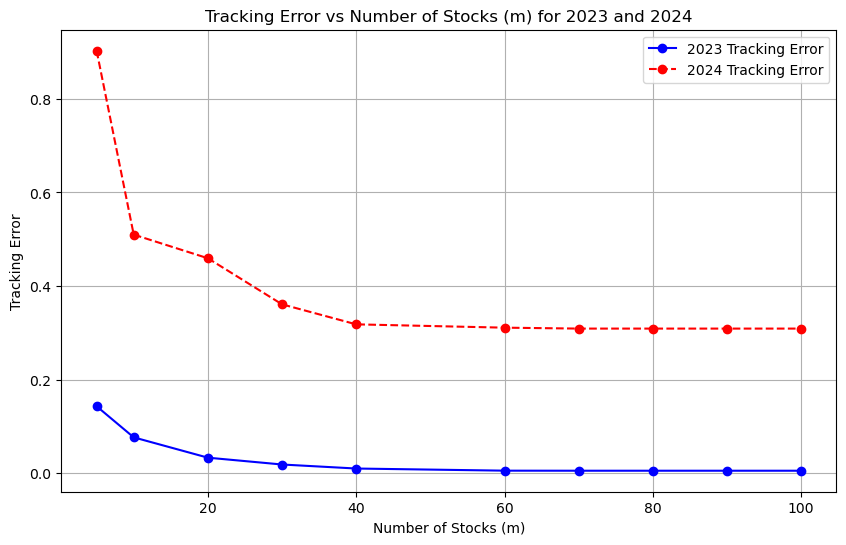

In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load stock returns and index returns for 2023 and 2024
stock_returns_2023 = returns_2023.drop(columns=['NDX'])
index_returns_2023 = returns_2023['NDX']
stock_returns_2024 = returns_2024.drop(columns=['NDX'])
index_returns_2024 = returns_2024['NDX']

# Function to calculate tracking error
def calculate_tracking_error(portfolio_returns, index_returns):
    # Calculate absolute deviations and sum them up
    return abs(portfolio_returns - index_returns).sum()

# Initialize dictionaries to store tracking errors for each year
tracking_errors_2023 = {}
tracking_errors_2024 = {}

# List of m values
m_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Calculate tracking errors for each m for both 2023 and 2024 data
for m in m_values:
    filename = f"portfolio_results_m_{m}.csv"
    if os.path.exists(filename):
        portfolio_data = pd.read_csv(filename)
        selected_stocks = portfolio_data[portfolio_data['Selected'] > 0.5]
        weights = selected_stocks['Weight'].values
        selected_stock_names = selected_stocks['Stock'].tolist()

        # Calculate daily portfolio returns for 2023 and 2024 using the selected weights
        selected_returns_2023 = stock_returns_2023[selected_stock_names]
        selected_returns_2024 = stock_returns_2024[selected_stock_names]
        portfolio_returns_2023 = selected_returns_2023.dot(weights)
        portfolio_returns_2024 = selected_returns_2024.dot(weights)

        # Calculate tracking errors
        tracking_errors_2023[m] = calculate_tracking_error(portfolio_returns_2023, index_returns_2023)
        tracking_errors_2024[m] = calculate_tracking_error(portfolio_returns_2024, index_returns_2024)

        print(f"Tracking error for m = {m} (2023): {tracking_errors_2023[m]}")
        print(f"Tracking error for m = {m} (2024): {tracking_errors_2024[m]}")
    else:
        print(f"File not found: {filename}")

# Plotting tracking errors for both 2023 and 2024
plt.figure(figsize=(10, 6))
plt.plot(list(tracking_errors_2023.keys()), list(tracking_errors_2023.values()), marker='o', linestyle='-', color='b', label='2023 Tracking Error')
plt.plot(list(tracking_errors_2024.keys()), list(tracking_errors_2024.values()), marker='o', linestyle='--', color='r', label='2024 Tracking Error')
plt.title('Tracking Error vs Number of Stocks (m) for 2023 and 2024')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('Tracking Error')
plt.legend()
plt.grid(True)
plt.show()
